In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import gstools as gs
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches
import seaborn as sns
import warnings

from utils.visualization_nonlinear_forward_pumpingtest import *
from utils.MC_nonlinear_forward_pumpingtest import *
from utils.DGSA_light import DGSA_light
from inversion_methods.nonlinear_inverse_theta_jointML import *
from inversion_methods.nonlinear_inverse_ES import *
from inversion_methods.local_inversion_localPCA import *
plt.rcParams.update({'font.size': 15})

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/pythoninstance4cores/code/Users/hierarchicalBayes/hierarchical_Bayes/'
subpath = 'examples/nonlinear_forward_pumping_test/'

# Load and visualize observed data

In [3]:
num_x = 100
num_y = 100

# observed data
d_obs = np.load(path+subpath+'d_obs.npy').reshape(70,5)[:,0]

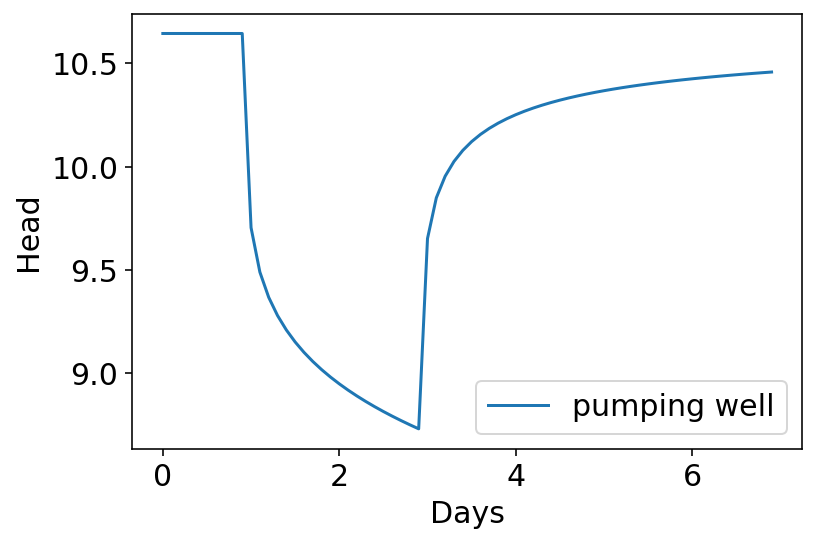

In [4]:
visualize_one_d(d_obs)

## Sneak peek: true model variables

In [5]:
# true global variable, theta_true
theta_name = ['mean', 'variance', 'max_range', 'min_range', 'anisotropy', 'head_west']
theta_true = np.load(path+subpath+'theta_true.npy')
# true spatial variable, m_true
m_true = np.load(path+subpath+'m_true.npy')

       mean  variance  max_range  min_range  anisotropy  head_west
theta  -1.6       0.3       20.0        7.0       120.0       11.0


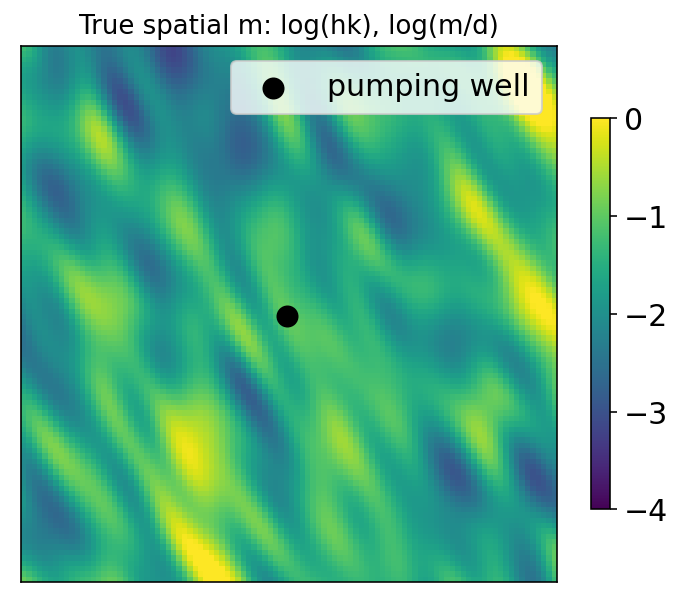

In [6]:
print_theta(theta_true)
visualize_one_m(m_true,vmin = -4,vmax = 0,title = 'True spatial m: log(hk), log(m/d)')

# Monte Carlo sampling: m, theta, d

In [7]:
# MC sampled global variable, theta
theta = np.load(path+subpath+'theta.npy')
# MC sampled spatial variable, m
m = np.load(path+subpath+'m.npy')
# MC sampled spatial variable, d
d = np.load(path+subpath+'d.npy')

success_index_modflow = np.unique(np.where(~np.isnan(d))[1])
d = d[:,success_index_modflow]
m = m[success_index_modflow,:,:]
theta = theta[success_index_modflow,:]
d = d.reshape(70,5,-1)[:,0,:]

In [8]:
print_theta_multiple(theta)

             mean  variance  max_range  min_range  anisotropy  head_west
theta_1 -1.902373  0.430102  26.224020   8.861379   70.591133  11.524813
theta_2 -1.569621  0.367862  17.703041  12.124766    7.408186  10.124884
theta_3 -1.794473  0.161740  20.835347  10.809853  166.194102  11.472230
theta_4 -1.910234  0.417275  15.564003   9.631377   73.122295  11.110236
theta_5 -2.152690  0.308976  15.176816  14.436460  169.970793  11.877284
theta_6 -1.708212  0.786635  29.944018  12.423964  130.090408  11.702856
theta_7 -2.124826  0.200465  22.322950  14.444667  165.297591   8.677102
theta_8 -1.216454  0.229313  20.580371  13.026061  148.188157  10.319856


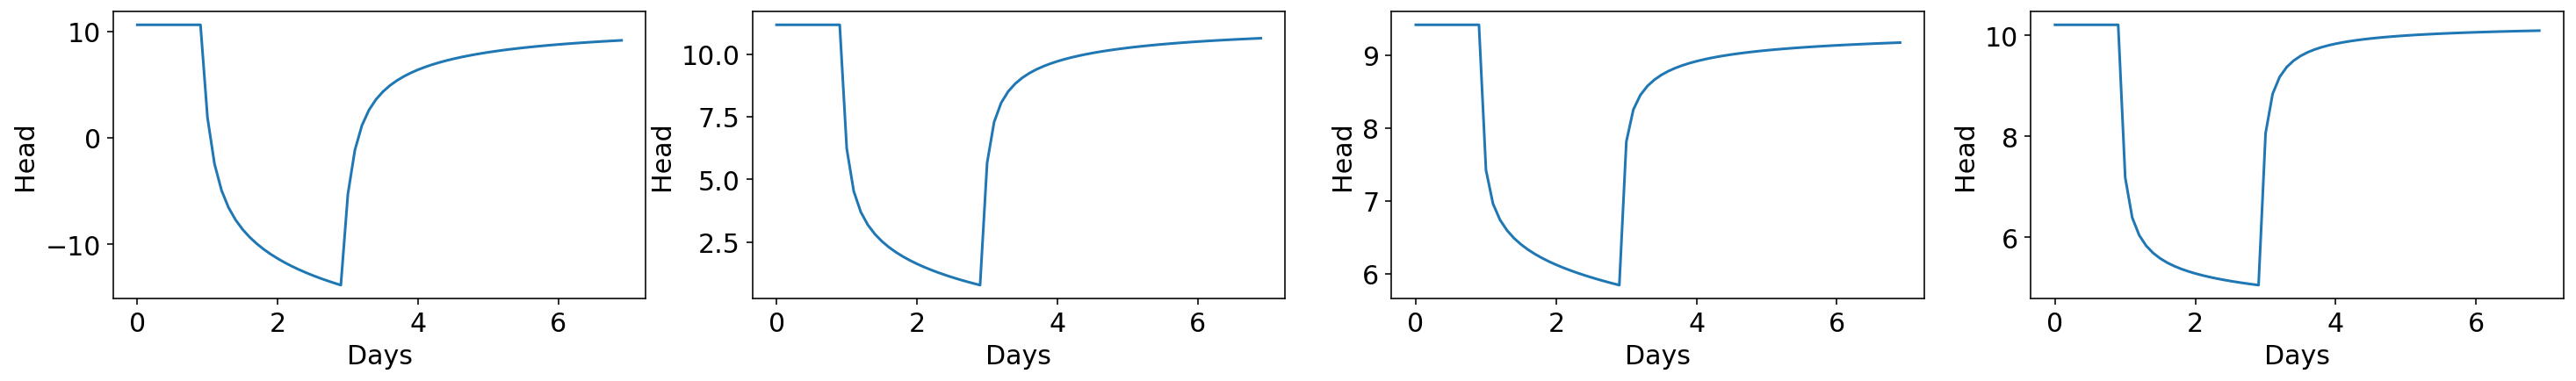

In [9]:
visualize_multiple_d(d[:,4:], head = 4)

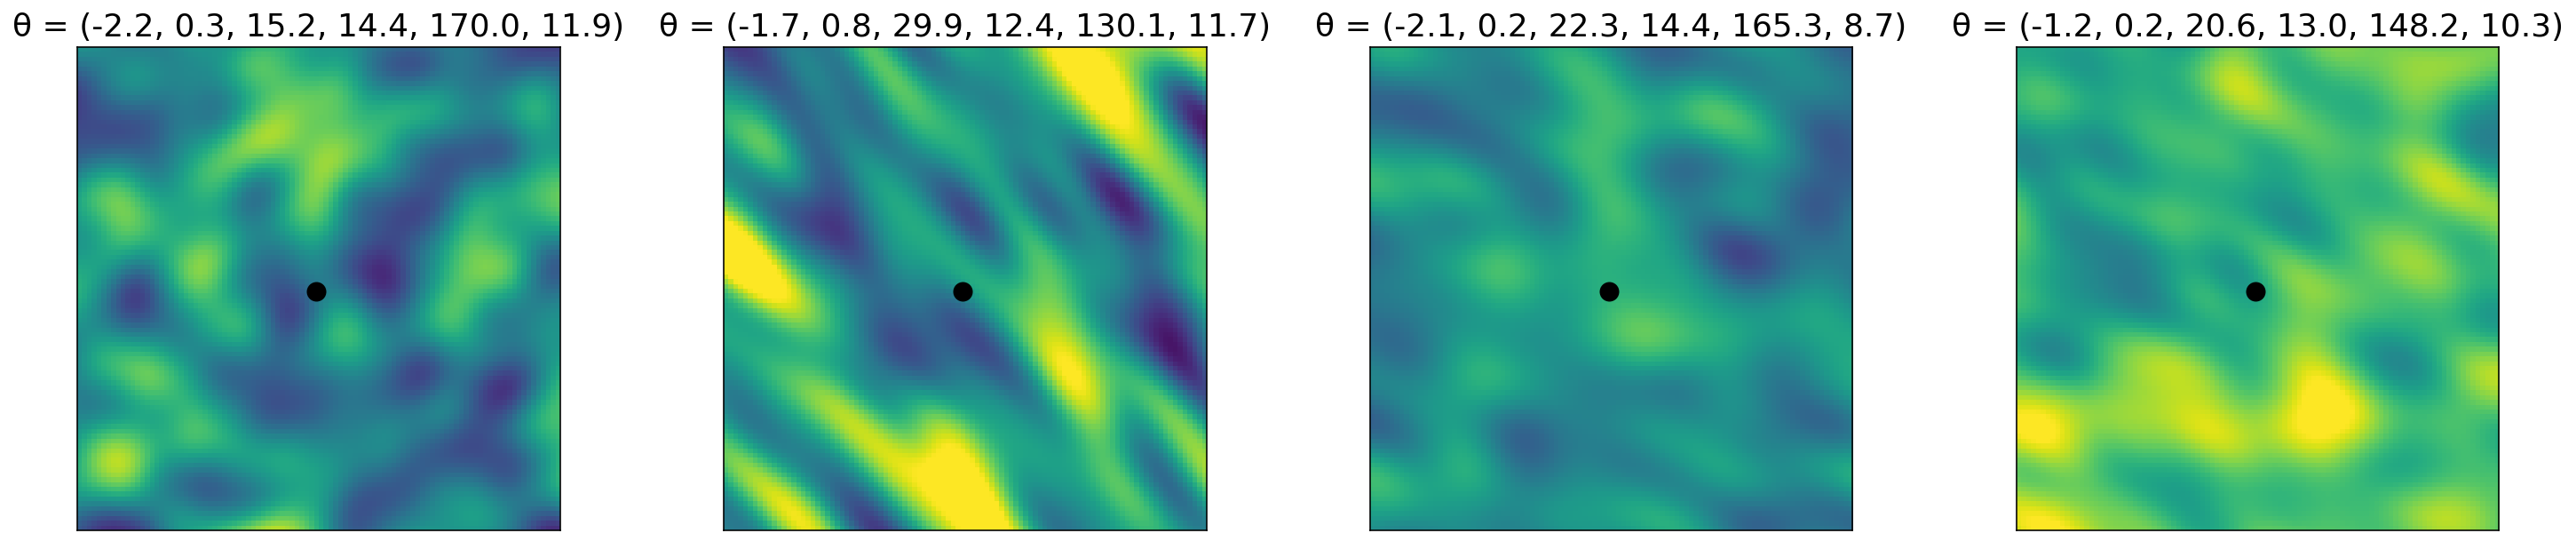

In [10]:
visualize_multiple_m(m[4:,:,:], head = 4,vmin = -4,vmax = 0,theta = theta[4:,:])

# Sensitivity analysis on global variable

In [11]:
# Sensitivity analysis on d
dgsa_d_theta = DGSA_light(theta, d.T, theta_name,n_clsters=4,n_boots = 3000)
dgsa_d_theta['name'] = theta_name
dgsa_d_theta['sensitive'] = (dgsa_d_theta[0]>1)*1

100%|██████████| 3000/3000 [00:10<00:00, 299.74it/s]


Text(0.5, 1.0, 'Sensitivity analysis: observed drawdown curves')

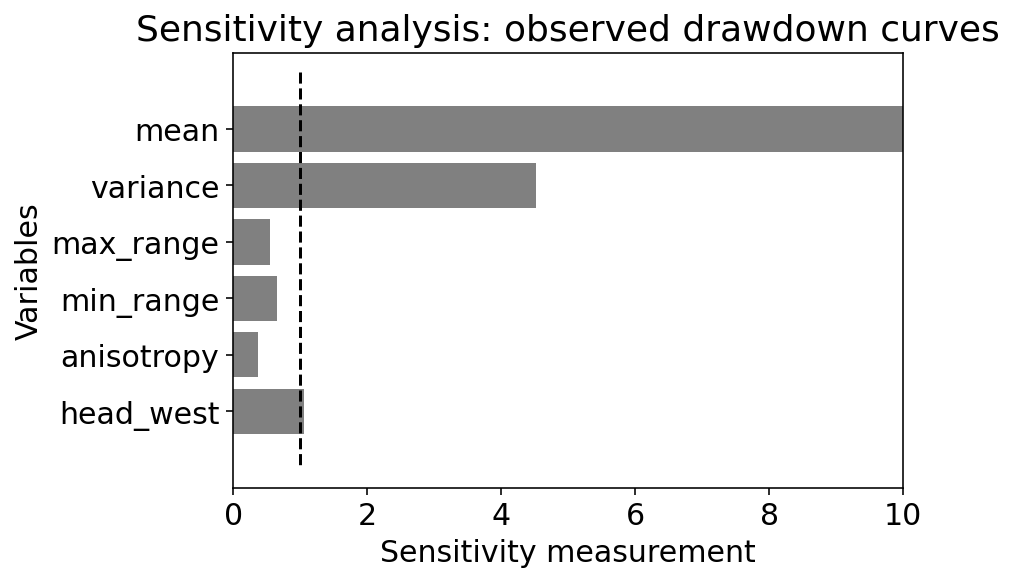

In [12]:
sns.barplot(x = 0,y = 'name', data=dgsa_d_theta,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(theta_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,10)
plt.title('Sensitivity analysis: observed drawdown curves')

# Hierarchical Bayes: inverse global variable

In [47]:
from sklearn.decomposition import PCA
num_d = d.shape[0]
num_pcs = d.shape[0]
pca = PCA(n_components=num_pcs)
pca.fit(d.T)
d_pcs = pca.transform(d.T)
d_obs_pcs = pca.transform(d_obs.reshape(1,num_d)).T

pc_cutoff = np.where(np.cumsum(pca.explained_variance_ratio_)>1-1e-10)[0][0]

In [57]:
prior_min_theta = np.array([-3,0.1,15,5,0, 8])
prior_max_theta = np.array([-1,1,30,15,180,12]) 

# ML dimension reduction
S_d, S_d_obs,pred_train, y_train, pred_test,y_test,history = ML_dimension_reduction(d_pcs[:,:pc_cutoff], 
                                                                                    d_obs_pcs[:pc_cutoff,:], 
                                                                                    theta, 
                                                                                    prior_min_theta, 
                                                                                    prior_max_theta,
                                                                                    custom_loss_function_case2,
                                                                                    learning_rate = 2e-3, 
                                                                                    num_input = 30,
                                                                                    num_epoch = 1000,
                                                                                    batch_size = 100)

0epoch [00:00, ?epoch/s]

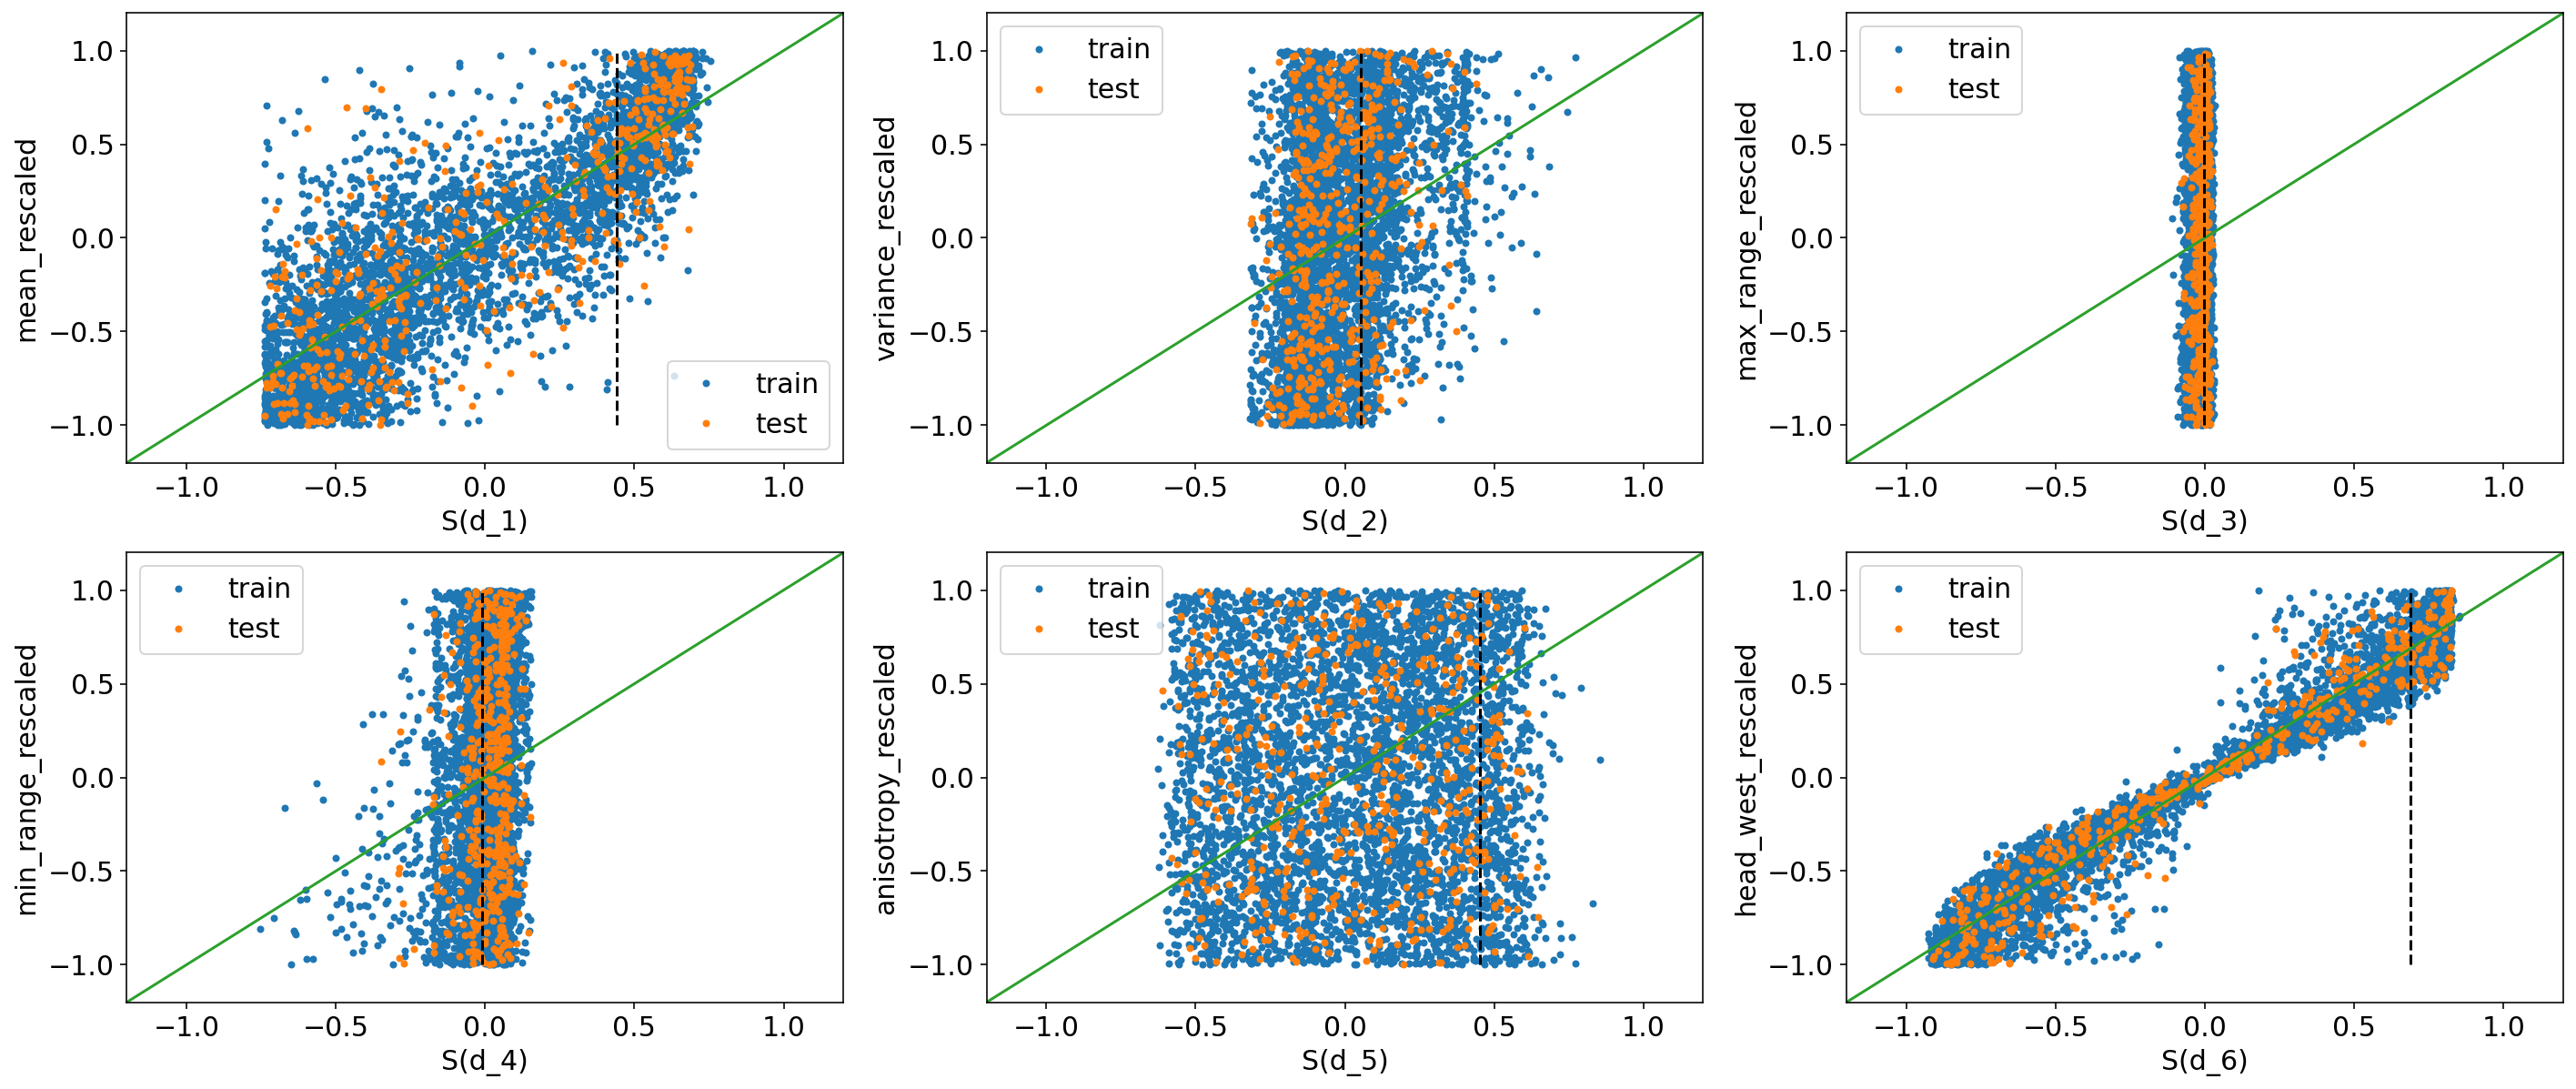

In [58]:
# visualize ML dimenison reduction result
ML_dimension_reduction_vis(pred_train, y_train, pred_test, y_test, S_d_obs, theta_name)

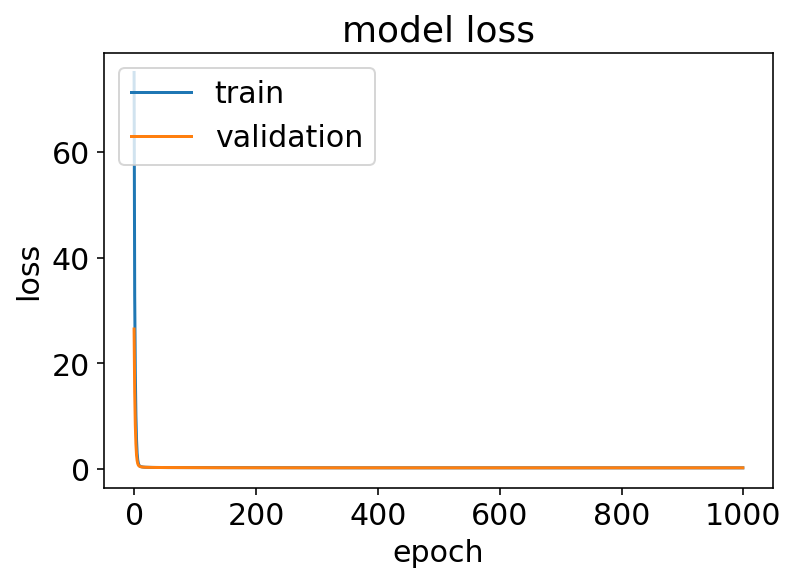

In [59]:
# visualize training history
history_plot(history)

In [60]:
# posterior sampling from joint distribution
theta_pos_MC = posterior_global_samples_jointML(S_d, S_d_obs, theta, prior_min_theta, prior_max_theta)

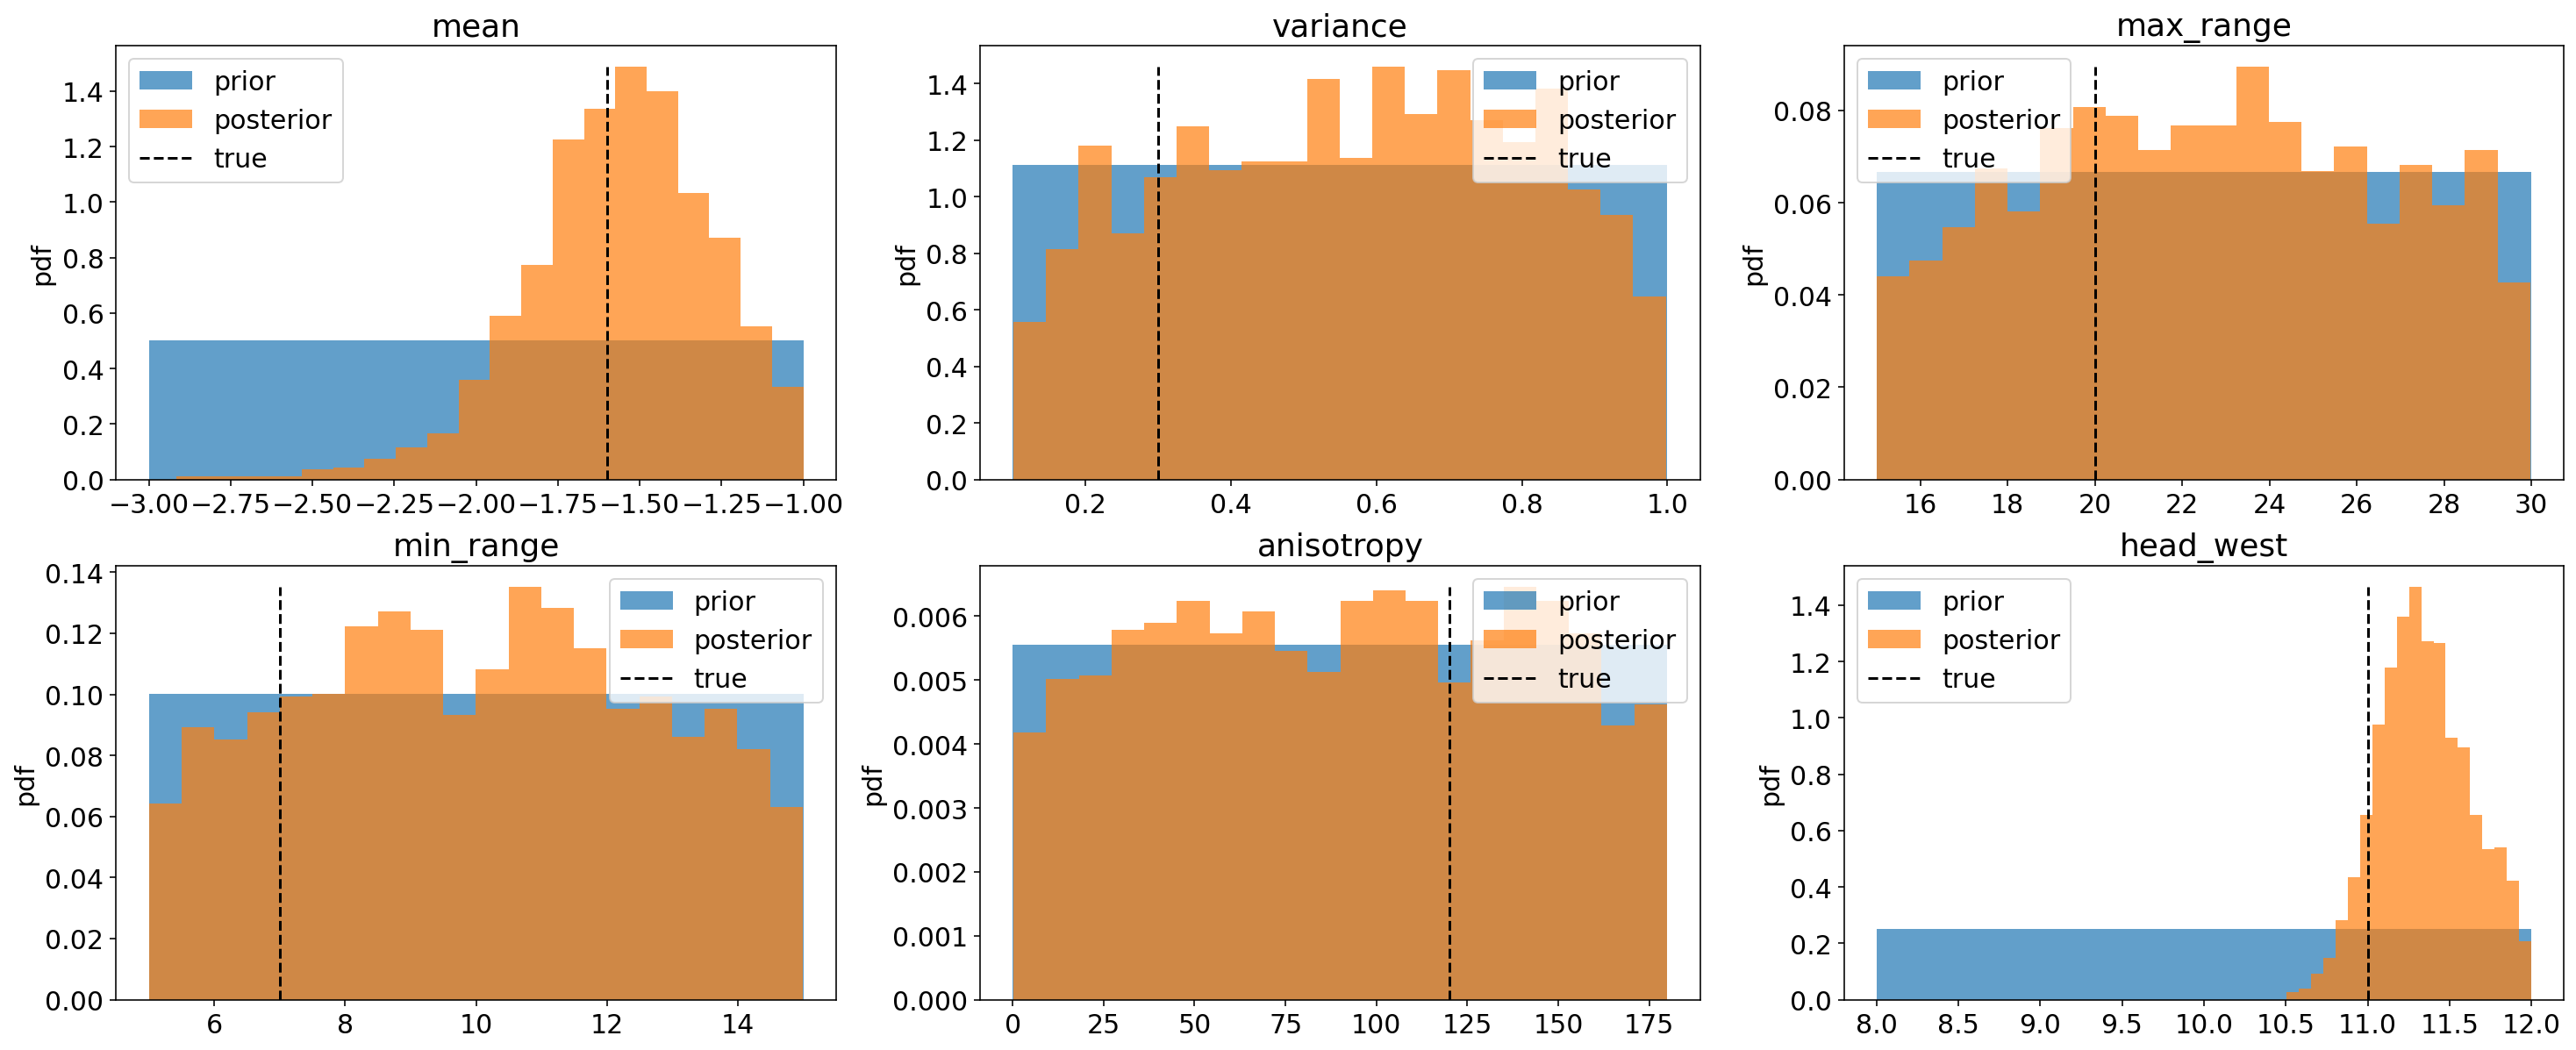

In [61]:
# visualize prior and posterior
prior_pos_theta(theta, theta_pos_MC, theta_true, theta_name)

In [65]:
np.save('saved_inverse_results/posterior_case2.npy',theta_pos_MC)

In [66]:
theta_pos_MC = np.load('saved_inverse_results/posterior_case2.npy')

# Hierarchical Bayes: inverse spatial variable

## Compare local spatial inversion and spatial inversion

Random sample the posterior global varible $\theta ~ p(\theta|d_{obs})$ and solve the spatial inversion $p(m|\theta,d_{obs})$

In [62]:
real_idx = 0
theta_pos_real = theta_pos_MC[:,real_idx]

In [63]:
print_theta(theta_pos_real)

           mean  variance  max_range  min_range  anisotropy  head_west
theta -1.599015  0.227902  16.503622   8.358117  165.117007  11.791943


Sample 100 realizations of $m$ given fixed $\theta$

In [67]:
num_pos_sample = 100
loghk_posterior = generate_m_MC_same_theta(theta_pos_real,num_sample = num_pos_sample)
np.save('saved_inverse_results/loghk_posterior'+str(real_idx)+'.npy',loghk_posterior)

100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Run non-linear forward modeling, modflow simulation: 

In [68]:
pumping_rate = -10.
well_location = [49,49]
observed_wells = [[41,41],[57,57],[41,57],[57,41]]

In [69]:
drawdown_pos = np.zeros((70*5,num_pos_sample))
    
# forward modeling
for i in tqdm(range(num_pos_sample)):
    fname = 'pumping_test_pos'
    hwest = theta_pos_real[-1]
    loghk = loghk_posterior[i,:,:]
    drawdown_curves = run_modflow(fname, nrow, ncol, 
                                  hwest, loghk, pumping_rate, 
                                  well_location, observed_wells, 
                                  path = modflowpath)
    drawdown_pos[:,i] = drawdown_curves
np.save('saved_inverse_results/drawdown_pos_'+str(real_idx)+'.npy',drawdown_pos)

100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


In [77]:
drawdown_pos = drawdown_pos.reshape(70,5,-1)[:,0,:]

Visualize 100 realizations of $m$ given fixed $\theta$

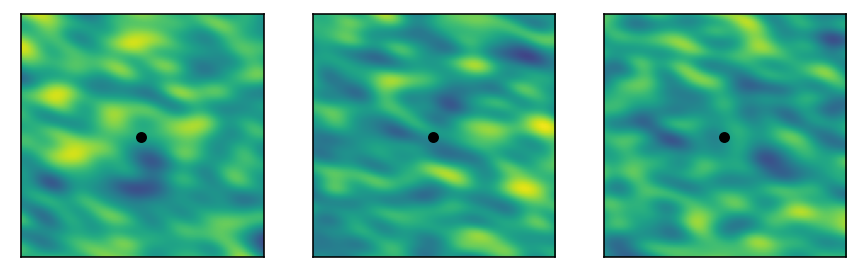

In [252]:
visualize_multiple_m(loghk_posterior.reshape(num_pos_sample,100,100),vmin = -4, vmax = 0,head = 3)

Sensitivity analysis: the global principal components

In [73]:
global_PCA_result = PCA_fast(loghk_posterior.reshape(-1,10000).T)

In [80]:
# pos data_PCA
pca = PCA(n_components=70)
pca.fit(drawdown_pos.T)
d_pos_pcs = pca.transform(drawdown_pos.T)
d_obs_pos_pcs = pca.transform(d_obs.reshape(1,num_d)).T
#d_obs_pos_pcs = pca.transform(drawdown_pos[:,0].reshape(1,num_d)).T

In [147]:
# Sensitivity analysis: global PC
num_PC_sensitive = 10
globalPC_name = ['PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
dgsa_d_global_m = DGSA_light(global_PCA_result['pc_scores'][:num_PC_sensitive,:].T, drawdown_pos.T, 
                             globalPC_name,n_clsters=4,n_boots = 3000)
dgsa_d_global_m['name'] = globalPC_name
dgsa_d_global_m['sensitive'] = (dgsa_d_global_m[0]>1)*1

100%|██████████| 3000/3000 [00:02<00:00, 1155.00it/s]


(0.0, 1.5)

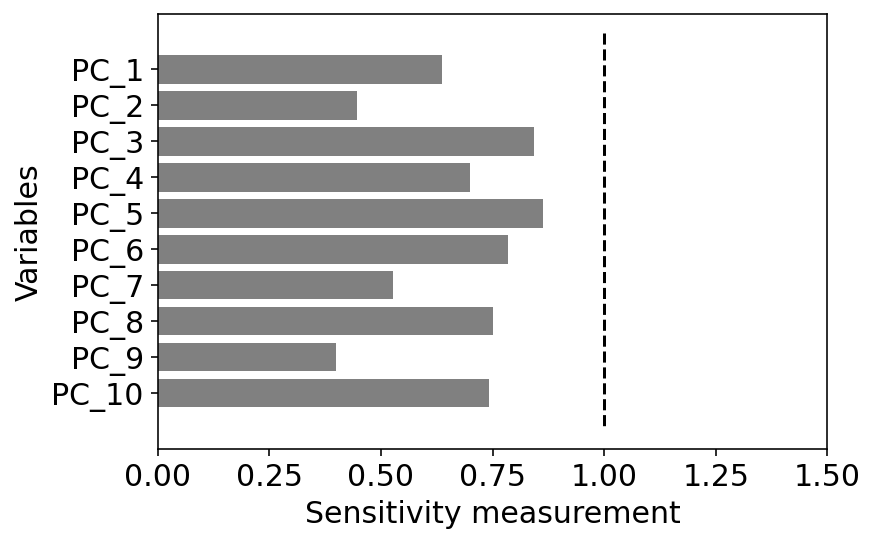

In [148]:
sns.barplot(x = 0,y = 'name', data=dgsa_d_global_m,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(globalPC_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,1.5)
#plt.title('Sensitivity analysis: observed drawdown curves')

find the local area size

In [113]:
# find the local area size
num_PC_sensitive = 20
dgsa_local = np.zeros((13,20))
i = 0
for local_boundary in np.arange(2,51,4):
    local_indicator = np.zeros((nrow,ncol))
    local_indicator[:] = np.nan
    local_indicator[np.int(50-local_boundary):np.int(50+local_boundary),np.int(50-local_boundary):np.int(50+local_boundary)] = 1
    lobal_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(-1,10000).T, local_indicator, project = True)
    # Sensitivity analysis: local PC
    localPC_name = ['local_PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
    dgsa_d_local_m = DGSA_light(local_PCA_result['pc_scores'][:num_PC_sensitive,:].T,  drawdown_pos.T, 
                                localPC_name,n_clsters=4,n_boots = 3000)
    #dgsa_d_local_m['name'] = localPC_name
    #dgsa_d_local_m['sensitive'] = (dgsa_d_local_m[0]>1)*1
    
    dgsa_local[i,:] = dgsa_d_local_m[0]
    i = i+1

100%|██████████| 3000/3000 [00:03<00:00, 945.90it/s]


Text(0.5, 1.0, '# of sensitive principal components')

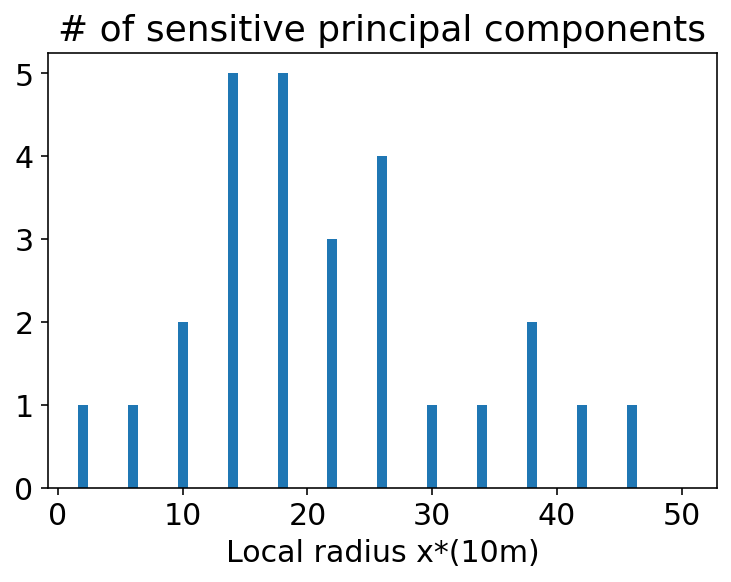

In [123]:
plt.bar(np.arange(2,51,4),np.sum(dgsa_local[:,:10]>1,axis = 1))
plt.xlabel('Local radius x*(10m)')
plt.title('# of sensitive principal components')

Sensitivity analysis: the local principal components

In [153]:
num_PC_sensitive = 10
local_boundary = 18
local_indicator = np.zeros((nrow,ncol))
local_indicator[:] = np.nan
local_indicator[np.int(50-local_boundary):np.int(50+local_boundary),np.int(50-local_boundary):np.int(50+local_boundary)] = 1

In [160]:
global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_posterior.reshape(-1,10000).T, local_indicator, project = True)

In [161]:
# Sensitivity analysis: local PC
localPC_name = ['local_PC_'+str(i) for i in np.arange(1,num_PC_sensitive+1)]
dgsa_d_local_m = DGSA_light(local_PCA_result['pc_scores'][:num_PC_sensitive,:].T,  drawdown_pos.T, 
                            localPC_name,n_clsters=4,n_boots = 3000)
dgsa_d_local_m['name'] = localPC_name
dgsa_d_local_m['sensitive'] = (dgsa_d_local_m[0]>1)*1

100%|██████████| 3000/3000 [00:02<00:00, 1096.04it/s]


(0.0, 1.5)

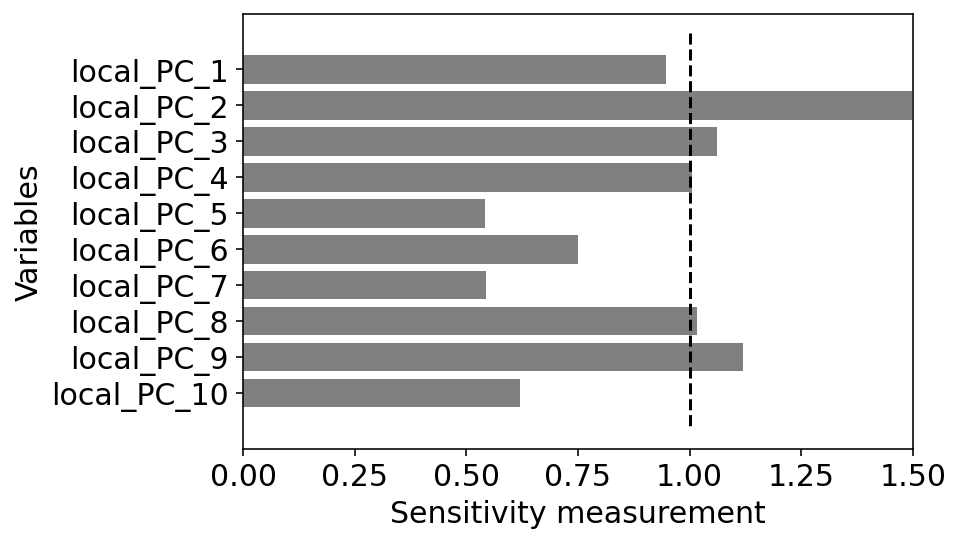

In [156]:
sns.barplot(x = 0,y = 'name', data=dgsa_d_local_m,color = 'grey')
plt.vlines(x = 1, ymin = -1, ymax = len(localPC_name),color = 'black',linestyle = '--')
plt.xlabel('Sensitivity measurement')
plt.ylabel('Variables')
plt.xlim(0,1.5)
#plt.title('Sensitivity analysis: observed drawdown curves')

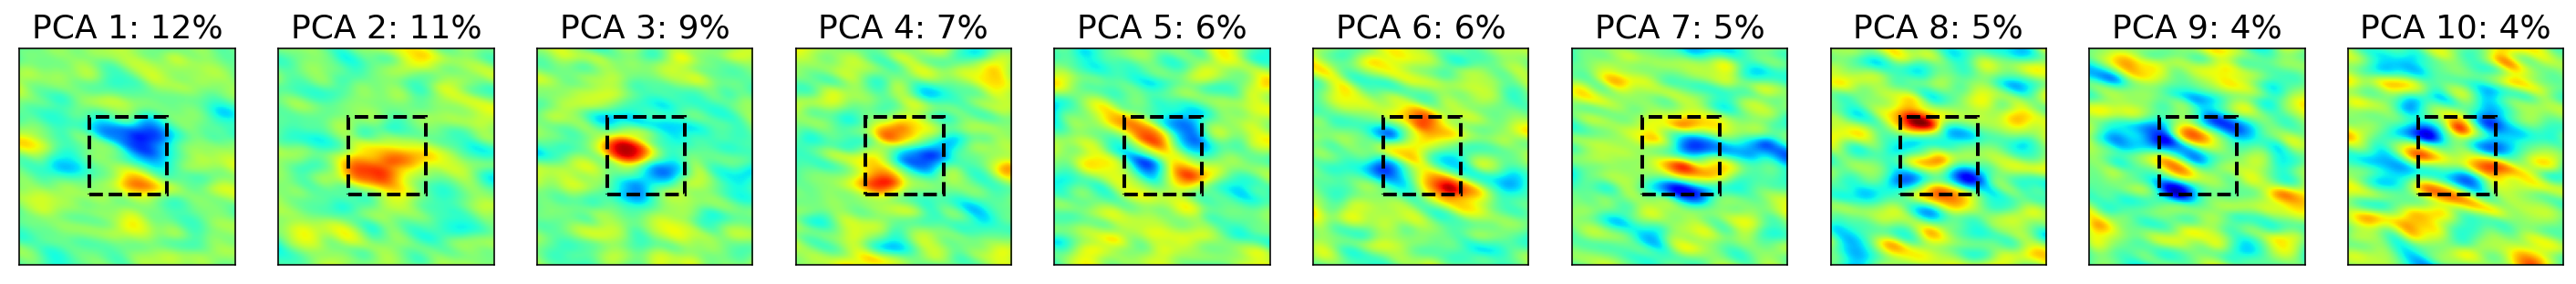

In [174]:
visualize_multiple_pc(local_PCA_result['eigen_vectors_all'].T.reshape(num_pos_sample,100,100)[:,:,:],local_PCA_result,
                     head = 10,
                     vmin = -0.08, vmax = 0.08,cmap = 'jet',rect = True)

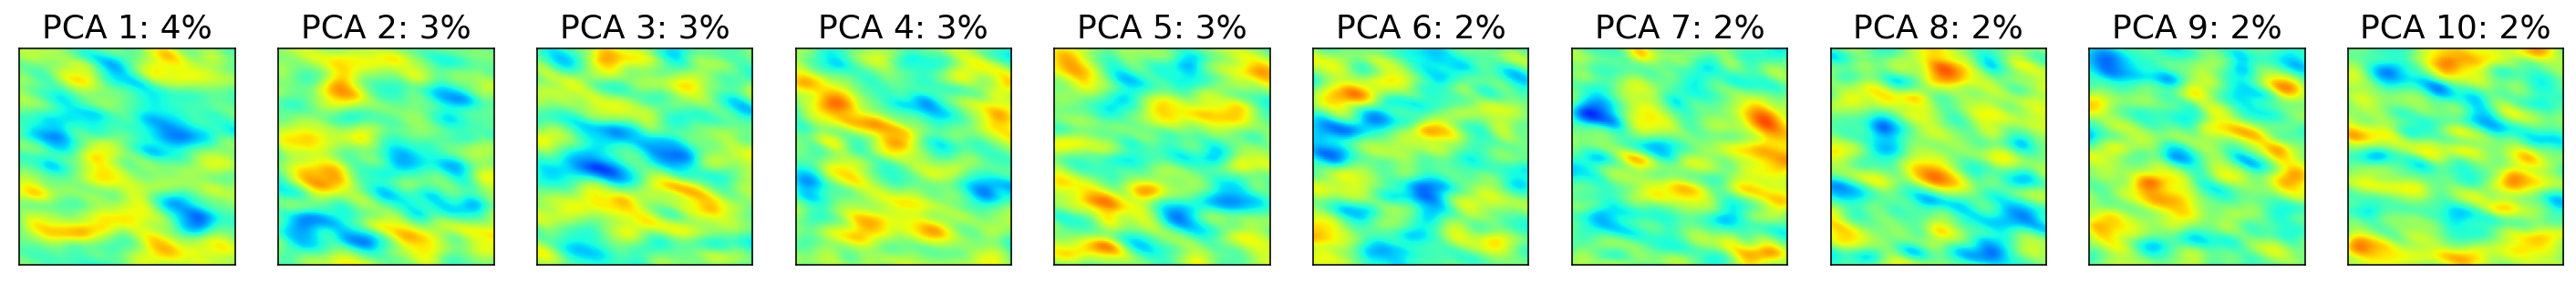

In [176]:
visualize_multiple_pc(global_PCA_result['eigen_vectors'].T.reshape(num_pos_sample,100,100), global_PCA_result,head = 10,
                     vmin = -0.05, vmax = 0.05,cmap = 'jet')

# Ensemble smoother: inversion

In [177]:
m_pos_global = ensemble_smoother(global_PCA_result['pc_scores'][:30,:],d_pos_pcs[:100,:10].T,d_obs_pos_pcs[:10,:100])
m_pos_reconstruct_global = reconstruction(global_PCA_result,
                                          pc_scores=np.vstack([m_pos_global,
                                                               global_PCA_result['pc_scores'][30:,:]]),
                                          n_component=num_pos_sample)

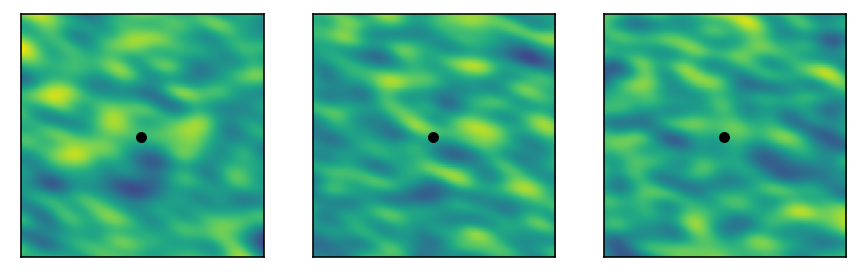

In [243]:
visualize_multiple_m(m_pos_reconstruct_global.T.reshape(-1,100,100)[:,:,:],vmin = -4, vmax = 0,head = 3)

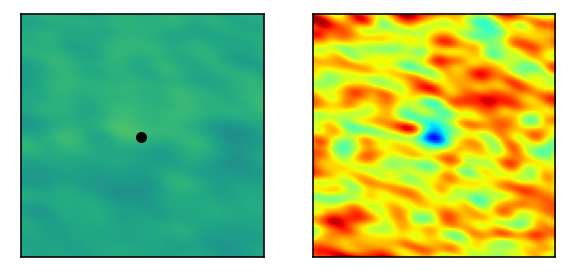

In [245]:
visualize_mean_var_MC(m_pos_reconstruct_global.T,32,36,vmin = -4, vmax = 0)

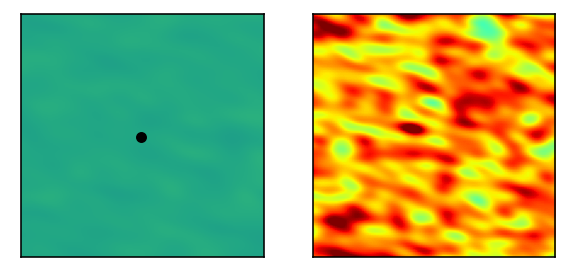

In [251]:
visualize_mean_var_MC(loghk_posterior,32,36,vmin = -4, vmax = 0)

In [186]:
m_pos_local = ensemble_smoother(local_PCA_result['pc_scores'][:30,:],d_pos_pcs[:100,:10].T,d_obs_pos_pcs[:10,:100])
m_pos_reconstruct_local = reconstruction_localPCA(global_PCA_result,
                                                  local_PCA_result,
                                                  pc_scores=np.vstack([m_pos_local,local_PCA_result['pc_scores'][30:,:]]),
                                                  n_component=num_pos_sample-1)

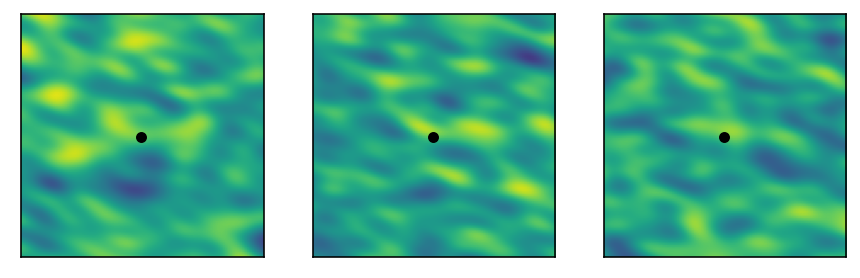

In [246]:
visualize_multiple_m(m_pos_reconstruct_local.T.reshape(-1,100,100)[:,:,:],vmin = -4, vmax = 0,head = 3)

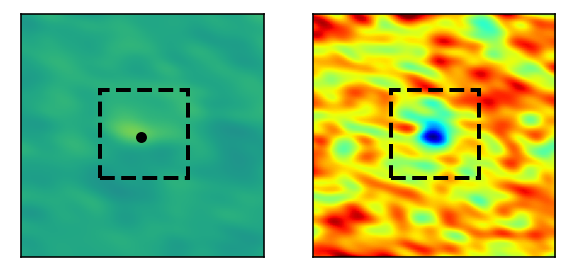

In [248]:
visualize_mean_var_MC(m_pos_reconstruct_local.T,32,36,vmin = -4, vmax = 0,rect = True)

In [216]:
diff_mean = np.mean(m_pos_reconstruct_global.T,axis = 0)-np.mean(m_pos_reconstruct_local.T,axis = 0)

In [217]:
diff_var = np.var(m_pos_reconstruct_global.T,axis = 0)-np.var(m_pos_reconstruct_local.T,axis = 0)

[]

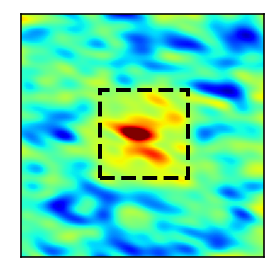

In [255]:
plt.figure(figsize = [10,4])
ax = plt.subplot(1, 4, 1)
ax.imshow(diff_var.reshape(num_x,num_y).T, origin = 'lower', cmap = 'jet', vmin = -0.03, vmax = 0.03)
rect = patches.Rectangle((32,32),36, 36, linewidth=2,linestyle = 'dashed', edgecolor='black',facecolor='None', label = 'pilot area')
ax.add_patch(rect)
ax.set_xticks([])
ax.set_yticks([])

In [266]:
# plt.figure(figsize = [4,4])
# plt.imshow(diff_var.reshape(num_x,num_y).T,vmin = -0.03, vmax = 0.03,cmap = 'jet')
# plt.colorbar(orientation='horizontal')

In [190]:
drawdown_pos_global = np.zeros((70*5,num_pos_sample))

# forward modeling
for i in tqdm(range(num_pos_sample)):
    fname = 'pumping_test_pos_pos'
    hwest = theta_pos_real[-1]
    loghk = m_pos_reconstruct_global.T.reshape(num_pos_sample,100,100)[i,:,:]
    drawdown_curves = run_modflow(fname, nrow, ncol, 
                                  hwest, loghk, pumping_rate, 
                                  well_location, observed_wells, 
                                  path = modflowpath)
    drawdown_pos_global[:,i] = drawdown_curves
np.save('saved_inverse_results/drawdown_pos_global_'+str(real_idx)+'.npy',drawdown_pos)

100%|██████████| 100/100 [04:38<00:00,  2.78s/it]


In [191]:
drawdown_pos_local = np.zeros((70*5,num_pos_sample))

# forward modeling
for i in tqdm(range(num_pos_sample)):
    fname = 'pumping_test_pos_pos'
    hwest = theta_pos_real[-1]
    loghk = m_pos_reconstruct_local.T.reshape(num_pos_sample,100,100)[i,:,:]
    drawdown_curves = run_modflow(fname, nrow, ncol, 
                                  hwest, loghk, pumping_rate, 
                                  well_location, observed_wells, 
                                  path = modflowpath)
    drawdown_pos_local[:,i] = drawdown_curves
np.save('saved_inverse_results/drawdown_pos_local_'+str(real_idx)+'.npy',drawdown_pos)

100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


In [269]:
drawdown_pos_global = drawdown_pos_global.reshape(70,5,-1)[:,0,:]
drawdown_pos_local = drawdown_pos_local.reshape(70,5,-1)[:,0,:]

In [297]:
def visualize_ensemble_d(d,d_obs,ymin = None,ymax = 11.5):
    plt.plot(np.arange(70)/10, d,color  = 'C0')
    plt.plot(np.arange(70)/10, d_obs,color  = 'C1',linewidth = 2,label = 'observed data')
    plt.xlabel('Days')
    plt.ylabel('Head')
    plt.legend()
    plt.ylim(ymin,ymax)
    

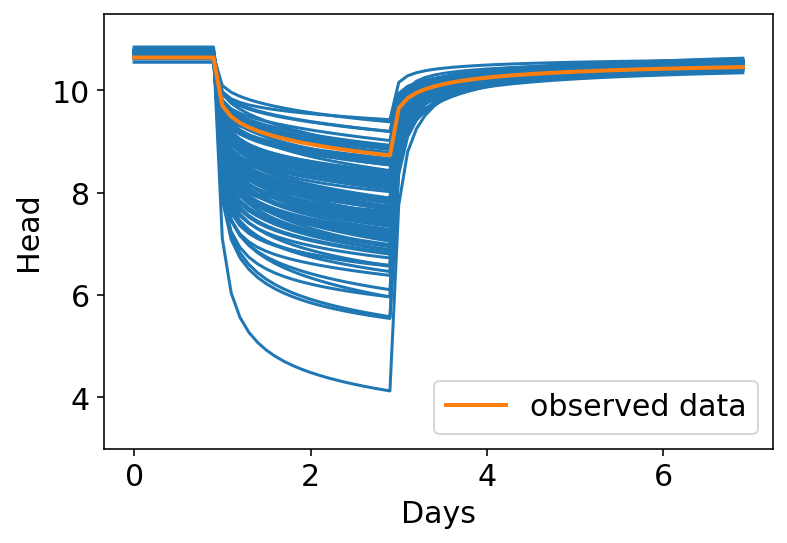

In [301]:
visualize_ensemble_d(drawdown_pos_global,d_obs,ymin = 3)

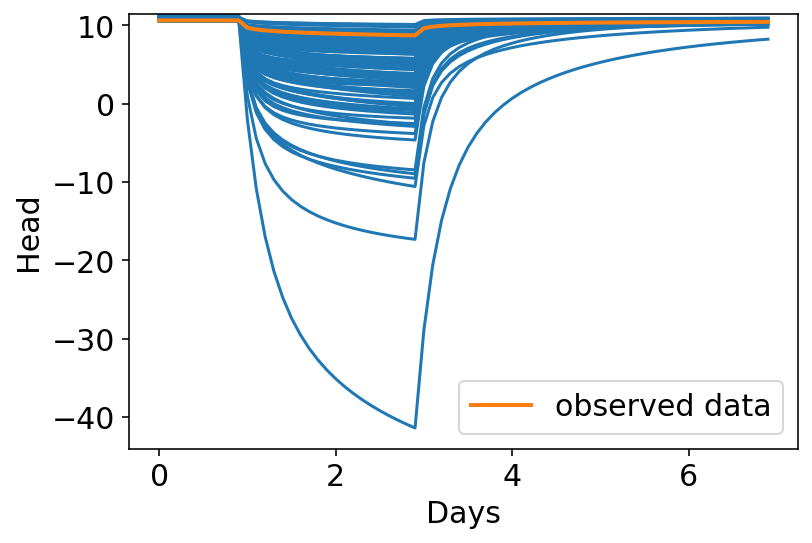

In [299]:
visualize_ensemble_d(drawdown_pos,d_obs)

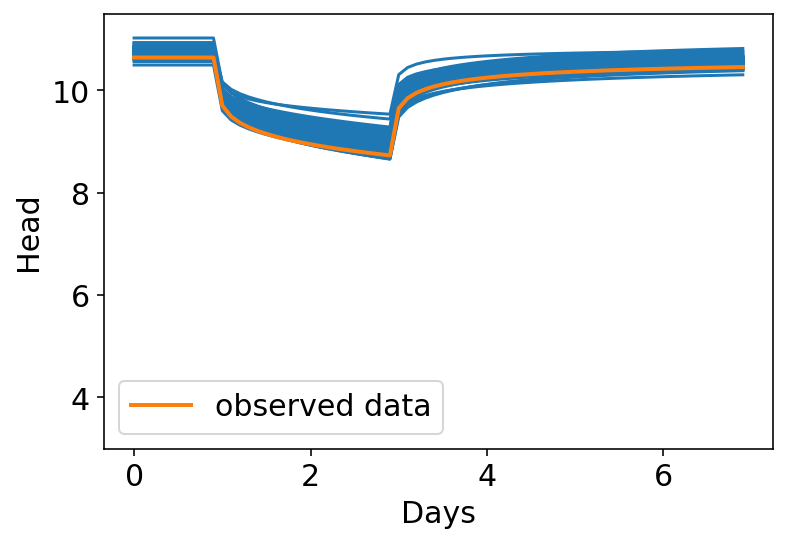

In [302]:
visualize_ensemble_d(drawdown_pos_local,d_obs,ymin = 3)

# Second iteration

In [303]:
loghk_pos_local = m_pos_reconstruct_local.T.reshape(num_pos_sample,100,100)

In [305]:
global_PCA_result,local_PCA_result,_,_ = local_PCA(loghk_pos_local.reshape(-1,10000).T, 
                                                   local_indicator, project = True)

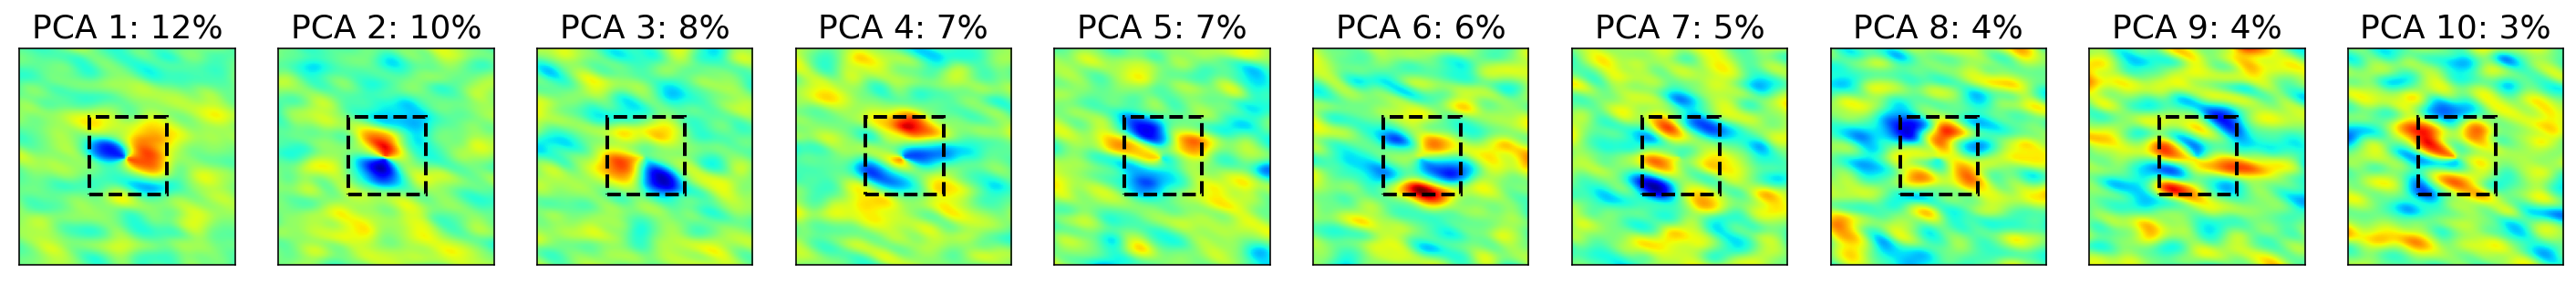

In [306]:
visualize_multiple_pc(local_PCA_result['eigen_vectors_all'].T.reshape(num_pos_sample,100,100)[:,:,:],local_PCA_result,
                      head = 10,
                      vmin = -0.08, vmax = 0.08,cmap = 'jet',rect = True)

In [314]:
# pos data_PCA
pca = PCA(n_components=70)
pca.fit(drawdown_pos.T)
d_pos_pcs = pca.transform(drawdown_pos_local.T)
d_obs_pos_pcs = pca.transform(d_obs.reshape(1,num_d)).T

In [315]:
m_pos_local = ensemble_smoother(local_PCA_result['pc_scores'][:30,:],d_pos_pcs[:100,:10].T,d_obs_pos_pcs[:10,:100])
m_pos_reconstruct_local = reconstruction_localPCA(global_PCA_result,
                                                  local_PCA_result,
                                                  pc_scores=np.vstack([m_pos_local,local_PCA_result['pc_scores'][30:,:]]),
                                                  n_component=num_pos_sample-1)

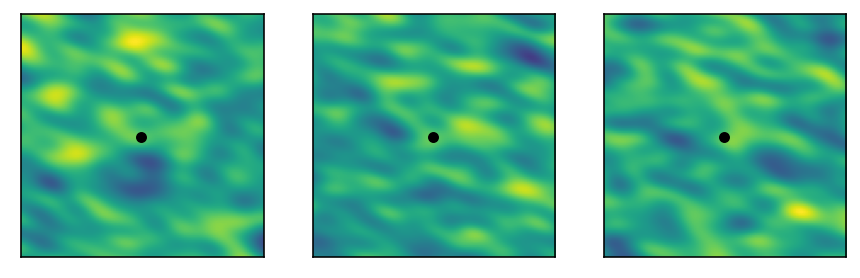

In [316]:
visualize_multiple_m(m_pos_reconstruct_local.T.reshape(-1,100,100)[:,:,:],vmin = -4, vmax = 0,head = 3)

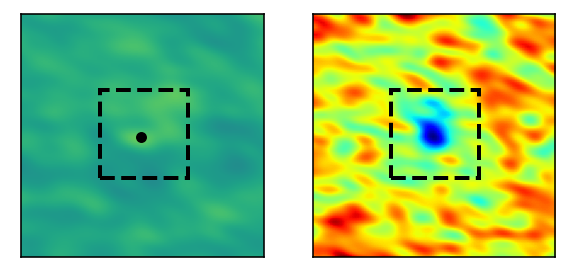

In [317]:
visualize_mean_var_MC(m_pos_reconstruct_local.T,32,36,vmin = -4, vmax = 0,rect = True)

In [318]:
drawdown_pos_pos_local = np.zeros((70*5,num_pos_sample))

# forward modeling
for i in tqdm(range(num_pos_sample)):
    fname = 'pumping_test_pos_pos'
    hwest = theta_pos_real[-1]
    loghk = m_pos_reconstruct_local.T.reshape(num_pos_sample,100,100)[i,:,:]
    drawdown_curves = run_modflow(fname, nrow, ncol, 
                                  hwest, loghk, pumping_rate, 
                                  well_location, observed_wells, 
                                  path = modflowpath)
    drawdown_pos_pos_local[:,i] = drawdown_curves
np.save('saved_inverse_results/drawdown_pos_pos_local_'+str(real_idx)+'.npy',drawdown_pos)

100%|██████████| 100/100 [04:48<00:00,  2.88s/it]


In [319]:
drawdown_pos_pos_local = drawdown_pos_pos_local.reshape(70,5,-1)[:,0,:]

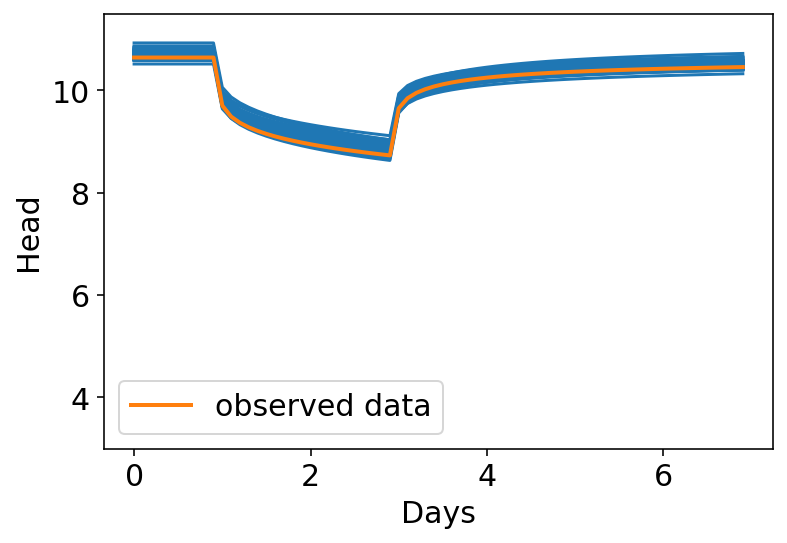

In [322]:
visualize_ensemble_d(drawdown_pos_pos_local,d_obs,ymin = 3)

In [ ]:
drawdown_pos_pos_global = np.zeros((70*5,num_pos_sample))

# forward modeling
for i in tqdm(range(num_pos_sample)):
    fname = 'pumping_test_pos_pos'
    hwest = theta_pos_real[-1]
    loghk = m_pos_reconstruct_global.T.reshape(num_pos_sample,100,100)[i,:,:]
    drawdown_curves = run_modflow(fname, nrow, ncol, 
                                  hwest, loghk, pumping_rate, 
                                  well_location, observed_wells, 
                                  path = modflowpath)
    drawdown_pos_global[:,i] = drawdown_curves
np.save('saved_inverse_results/drawdown_pos_pos_global_'+str(real_idx)+'.npy',drawdown_pos)